# Importa√ß√£o de bibliotecas e acesso a arquivos via Google Drive

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

DRIVE_FOLDER = '/content/drive/My Drive/DatasetColab/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pr√©-processamento de dados (igual ao c√≥digo anterior)

* Carrega um dataset de not√≠cias de futebol usando Pandas.
* Realiza limpeza e combina√ß√£o de colunas de texto.
* Aplica um LabelEncoder para transformar nomes de clubes em identificadores num√©ricos.
* Utiliza o spaCy para processamento de linguagem natural, como remover pontua√ß√£o, n√∫meros, acentos e aplicar lematiza√ß√£o.
* Instala e carrega um modelo de linguagem espec√≠fico para o portugu√™s.

In [ ]:
import pandas as pd

caminho_do_arquivo = DRIVE_FOLDER + 'ge_news.csv'
df = pd.read_csv(caminho_do_arquivo)

df.head()

date   time                                              title  \
0  10/11/2022  19h55  Convocados do Uruguai para a Copa do Mundo 202...   
1  22/12/2017  10h04  Conmebol divulga tabela detalhada da pr√© e da ...   
2  11/02/2018  08h00  Com assist√™ncia, Demethryus recebe elogios no ...   
3  18/12/2020  12h48  Athletico confirma fim de contrato com Welling...   
4  13/09/2018  22h17  Al√¥, cartoleiros! Atl√©tico-PR passa limpo cont...   

                                                text  \
0   O t√©cnico Diego Alonso divulgou a lista dos 2...   
1   Argentinos s√£o destaques no caminho dos brasi...   
2   O meia Demethryus conseguiu aproveitar bem a ...   
3   A reportagem do ge j√° havia adiantado que as ...   
4   O atacante Marcelo Cirino, desfalque j√° nos √∫...   

                                                link          club  
0  https://ge.globo.com/futebol/copa-do-mundo/not...  athletico-pr  
1  https://globoesporte.globo.com/futebol/liberta...  athletico-pr  
2  https://globoesporte.globo.com/pr/futebol/time...  athletico-pr  
3  https://globoesporte.globo.com/pr/futebol/time...  athletico-pr  
4  https://globoesporte.globo.com/pr/futebol/time...  athletico-pr

In [ ]:
# Removendo simultaneamente as colunas de √≠ndice 0, 1, 4 (date, time and link)
column_indices = [0, 1, 4]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

# Fundindo colunas 'title' e 'text' para a coluna 'title_and_text'
df['data'] = df['title'] + ' ' + df['text']

df.head()

title  \
0  Convocados do Uruguai para a Copa do Mundo 202...   
1  Conmebol divulga tabela detalhada da pr√© e da ...   
2  Com assist√™ncia, Demethryus recebe elogios no ...   
3  Athletico confirma fim de contrato com Welling...   
4  Al√¥, cartoleiros! Atl√©tico-PR passa limpo cont...   

                                                text          club  \
0   O t√©cnico Diego Alonso divulgou a lista dos 2...  athletico-pr   
1   Argentinos s√£o destaques no caminho dos brasi...  athletico-pr   
2   O meia Demethryus conseguiu aproveitar bem a ...  athletico-pr   
3   A reportagem do ge j√° havia adiantado que as ...  athletico-pr   
4   O atacante Marcelo Cirino, desfalque j√° nos √∫...  athletico-pr   

                                                data  
0  Convocados do Uruguai para a Copa do Mundo 202...  
1  Conmebol divulga tabela detalhada da pr√© e da ...  
2  Com assist√™ncia, Demethryus recebe elogios no ...  
3  Athletico confirma fim de contrato com Welling...  
4  Al√¥, cartoleiros! Atl√©tico-PR passa limpo cont...

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Treinando o codificador de r√≥tulos, transformando o nome do clube em um identificador num√©rico
df['label'] = le.fit_transform(df['club'])

# Removendo as colunas originais, n√£o precisamos mais delas
column_indices = [0, 1, 2]
df.drop([df.columns[i] for i in column_indices], axis=1, inplace=True)

df.head()

data  label
0  Convocados do Uruguai para a Copa do Mundo 202...      0
1  Conmebol divulga tabela detalhada da pr√© e da ...      0
2  Com assist√™ncia, Demethryus recebe elogios no ...      0
3  Athletico confirma fim de contrato com Welling...      0
4  Al√¥, cartoleiros! Atl√©tico-PR passa limpo cont...      0

In [ ]:
# Instalando uma vers√£o atualizada de um grande modelo de linguagem pr√©-treinado em portugu√™s
!pip install https://github.com/explosion/spacy-models/releases/download/pt_core_news_lg-3.7.0/pt_core_news_lg-3.7.0.tar.gz

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 568.2/568.2 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6.6/6.6 MB 44.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50.1/50.1 kB 6.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.0/45.0 kB 6.1 MB/s eta 0:00:00
  Created wheel for pt-core-news-lg: filename=pt_core_news_lg-3.7.0-py3-none-any.whl size=568212788 sha256=90b3b855e7c0b7c3088826993a104e5cc4e2654b9fb3a7f3630efc0c64501b9e
  Stored in directory: /root/.cache/pip/wheels/77/74/94/d4876f7b34383fdabdb61a2433a302ac487a87e8a6ce7925dc
Successfully built pt-core-news-lg
  At

In [ ]:
import string
import spacy
import unicodedata
from tqdm import tqdm
import pandas as pd
import numpy as np

# Habilita o suporte do tqdm para m√©todos de progress√£o do pandas (como progress_apply)
# Com isso, √© poss√≠vel ver barras de progresso em oper√ß√µes feitas no Pandas
tqdm.pandas()

# Carrega o modelo de linguagem 'pt_core_news_lg' do spaCy para processamento de texto em portugu√™s
# Desabilita os componentes 'parser' e 'ner', j√° que n√£o s√£o necess√°rios para a lematiza√ß√£o
spacy_nlp_model = spacy.load("pt_core_news_lg", disable=["parser", "ner"])

def preprocess_data(df, text_column):
    """
    Realiza o pr√©-processamento dos dados de texto em um DataFrame do Pandas.
    Remove pontua√ß√£o, n√∫meros e palavras comuns (stop words), converte para m√≠nusculas,
    remove acentos e s√≠mbolos diversos, e aplica lematiza√ß√£o.
    """

    # Cria uma tabela de tradu√ß√£o que mapeia cada caractere de pontua√ß√£o do m√≥dulo `string.punctuation`
    # para `None` (ou seja, remove-os do texto).
    print("Removendo pontua√ß√£o...")
    translator = str.maketrans('', '', string.punctuation) # S√≥ usamos o terceiro par√¢metro, que mapeia ocorr√™ncias de string.punctuation para None
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo n√∫meros...")
    translator = str.maketrans('', '', string.digits)
    df[text_column] = df[text_column].progress_apply(lambda x: x.translate(translator))

    print("Removendo acentos e s√≠mbolos diversos...")
    def remove_accents_and_symbols(text):
        try:
            # Normaliza a string para a forma NFKD e mant√©m apenas caracteres que n√£o s√£o diacr√≠ticos
            # nem combinam caracteres com diacr√≠ticos
            return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c) and unicodedata.category(c) != 'Mn')
        except TypeError:
            # Se n√£o for poss√≠vel normalizar um caractere, retorna uma string vazia
            return ''

    # Aplica a fun√ß√£o 'remove_accents_and_symbols' na coluna 'text_column'
    df[text_column] = df[text_column].progress_apply(lambda x: remove_accents_and_symbols(x))

    print("Convertendo para min√∫sculas...")
    df[text_column] = df[text_column].progress_apply(lambda x: x.lower())

    print("Computando Lematiza√ß√£o...")
    def lemmatize_text(doc):
        return [token.lemma_ for token in doc if not token.is_stop]

    n_chunks = 10  # Ajuste esse valor de acordo com o tamanho da base de dados e a mem√≥ria dispon√≠vel no sistema
    chunks = np.array_split(df, n_chunks) # Divide o dataframe em v√°rias partes

    processed_chunks = []
    for i, chunk in enumerate(chunks):
        print(f"Processando segmento {i + 1} de {n_chunks}")
        processed_chunk = chunk.copy() # Cria uma c√≥pia para realizar o processamento

        #  Aplica a fun√ß√£o 'lemmatize_text' a cada documento processado pelo spaCy (usando 'spacy_nlp_model.pipe') e
        # atribui os resultados (uma lista de palavras lematizadas) √† coluna 'text_column' do DataFrame 'processed_chunk'.
        # O tqdm √© utilizado para exibir uma barra de progresso durante o processamento dos documentos.
        processed_chunk[text_column] = [lemmatize_text(doc) for doc in tqdm(spacy_nlp_model.pipe(chunk[text_column].astype(str), batch_size=100, disable=['parser', 'ner']), total=len(chunk[text_column]))]

        # Junta as partes em uma lista, para formar o dataframe final
        processed_chunks.append(processed_chunk)

    concatenated_df = pd.concat(processed_chunks) # Concatenar os DataFrames processados
    df[text_column] = concatenated_df[text_column] # Atribuir a coluna 'data' processada de volta ao dataframe original

    print("Remover tokens com espa√ßos vazios...")
    df['data'] = df['data'].progress_apply(lambda x: [token for token in x if token.strip()])

In [ ]:
preprocess_data(df, 'data') # Realiza o pr√©-processamento

Removendo pontua√ß√£o...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191005/191005 [01:07<00:00, 2811.27it/s]


Removendo n√∫meros...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191005/191005 [00:56<00:00, 3384.19it/s]


Removendo acentos e s√≠mbolos diversos...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191005/191005 [03:06<00:00, 1021.72it/s]


Convertendo para min√∫sculas...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191005/191005 [00:01<00:00, 118707.85it/s]


Computando Lematiza√ß√£o...
Processando segmento 1 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [09:04<00:00, 35.10it/s]


Processando segmento 2 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [09:47<00:00, 32.53it/s]


Processando segmento 3 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [09:16<00:00, 34.29it/s]


Processando segmento 4 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [09:06<00:00, 34.96it/s]


Processando segmento 5 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [10:27<00:00, 30.42it/s]


Processando segmento 6 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19100/19100 [08:35<00:00, 37.02it/s]


Processando segmento 7 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19100/19100 [09:31<00:00, 33.43it/s]


Processando segmento 8 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19100/19100 [08:59<00:00, 35.37it/s]


Processando segmento 9 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19100/19100 [09:17<00:00, 34.26it/s]


Processando segmento 10 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19100/19100 [09:40<00:00, 32.90it/s]


Remover tokens com espa√ßos vazios...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191005/191005 [00:12<00:00, 15097.91it/s]


In [ ]:
# Salva em disco um dataframe com as not√≠cias de futebol j√° pr√©-processadas
df.to_pickle(DRIVE_FOLDER + 'ge_df.pkl')

# Prepara√ß√£o dos dados para o modelo de machine learning

* Realiza tokeniza√ß√£o dos textos, convertendo-os em sequ√™ncias num√©ricas que representam palavras.
* Calcula o comprimento m√°ximo das sequ√™ncias e aplica padding para normalizar o comprimento.
* Carrega embeddings pr√©-treinados do GloVe para representa√ß√£o vetorial das palavras.
* Prepara os r√≥tulos (labels) para treinamento usando one-hot encoding.

In [ ]:
import pandas as pd

# Carregamento do dataframe com not√≠cias pr√©-processadas
df = pd.read_pickle(DRIVE_FOLDER + 'ge_df.pkl')

In [ ]:
df.head()

data  label
0  [convocar, uruguai, copa, mundo, lista, tecnic...      0
1  [conmebol, divulgar, tabela, detalhar, pre, fa...      0
2  [assistencia, demethryus, receber, elogio, atl...      0
3  [athletico, confirmar, contrato, wellington, n...      0
4  [alo, cartoleiro, atleticopr, passar, limpo, c...      0

In [ ]:
texts = df['data'].tolist()  # Converte as not√≠cias em listas de palavras, algo que o Tokenizador espera
labels = df['label'].tolist()  # R√≥tulos das not√≠cias

In [ ]:
# Tokeniza√ß√£o
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [ ]:
#word_index √© um dicion√°rio onde as chaves s√£o as palavras e os valores s√£o os √≠ndices dessas palavras.
#Esse √≠ndice √© √∫til para v√°rias tarefas de NLP, como a cria√ß√£o de embeddings de palavras ou a prepara√ß√£o de dados para modelos de deep learning.
word_index

{'nao': 1,
 'jogo': 2,
 'gol': 3,
 'clube': 4,
 'sao': 5,
 'time': 6,
 'jogador': 7,
 'ano': 8,
 'equipe': 9,
 'partida': 10,
 'paulo': 11,
 '‚Äì': 12,
 'tambem': 13,
 'ja': 14,
 '‚Äî': 15,
 'ge': 16,
 'ate': 17,
 'ser': 18,
 'rodada': 19,
 'flamengo': 20,
 'vitoria': 21,
 'brasileiro': 22,
 'dia': 23,
 'ultimo': 24,
 'palmeira': 25,
 'campeonato': 26,
 'tecnico': 27,
 'noticia': 28,
 'bom': 29,
 'jogar': 30,
 'ficar': 31,
 'fotor': 32,
 'campo': 33,
 'futebol': 34,
 'copa': 35,
 'chegar': 36,
 'h': 37,
 'brasileirao': 38,
 'apos': 39,
 'marcar': 40,
 'brasil': 41,
 'santo': 42,
 'voce': 43,
 'serie': 44,
 'x': 45,
 'ter': 46,
 'gremio': 47,
 'fluminense': 48,
 'temporada': 49,
 'atacante': 50,
 'cruzeiro': 51,
 'gente': 52,
 'voltar': 53,
 'acabar': 54,
 'botafogo': 55,
 'bola': 56,
 'vasco': 57,
 'atleta': 58,
 'r': 59,
 'passar': 60,
 'so': 61,
 'proximo': 62,
 'vencer': 63,
 'sera': 64,
 'inter': 65,
 'libertador': 66,
 'casa': 67,
 'tres': 68,
 'entrar': 69,
 'fazer': 70,
 'ir': 7

In [ ]:
import pickle

# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as infer√™ncias)
with open(DRIVE_FOLDER + 'tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
import numpy as np

# Calcula o comprimento de cada sequ√™ncia em 'sequences' e armazena os resultados na lista 'sequence_lengths'
sequence_lengths = [len(seq) for seq in sequences]

# Calcula a m√©dia dos comprimentos das sequ√™ncias usando a fun√ß√£o 'mean' do numpy
mean_length = np.mean(sequence_lengths)

# Obt√©m o comprimento m√°ximo das sequ√™ncias usando a fun√ß√£o 'max' do Python
max_length = max(sequence_lengths)

# Imprime a m√©dia e o comprimento m√°ximo das sequ√™ncias
print("Mean sequence length: ", mean_length)
print("Maximum sequence length: ", max_length)

Mean sequence length:  207.9075155100652
Maximum sequence length:  4967


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula o percentil 95 dos comprimentos das sequ√™ncias (preserva 95% das sequ√™ncias)
max_length = int(np.percentile(sequence_lengths, 95))

# Realiza o preenchimento das sequ√™ncias com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# GLoVe

In [ ]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open(DRIVE_FOLDER + 'glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Preparar a matriz de embedding
embedding_dim = 100  # o tamanho do seu GLoVe embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# One-hot encoding dos r√≥tulos
num_classes = len(np.unique(labels))  # N√∫mero de classes √∫nicas
labels = to_categorical(labels, num_classes=num_classes)

In [ ]:
from sklearn.model_selection import train_test_split

# Divida os dados em um conjunto de treino (70%) e um conjunto tempor√°rio (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3)

# Divida o conjunto tempor√°rio em conjuntos de valida√ß√£o (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)  # 0.5 * 0.3 = 0.15

In [ ]:
# Construindo o modelo
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes, activation='softmax'))  # Camada de sa√≠da para classifica√ß√£o multiclasse

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size=128, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/40
1045/1045 [==============================] - 79s 69ms/step - loss: 1.3698 - accuracy: 0.6451 - val_loss: 0.9434 - val_accuracy: 0.7537
Epoch 2/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.8471 - accuracy: 0.7708 - val_loss: 0.7731 - val_accuracy: 0.7834
Epoch 3/40
1045/1045 [==============================] - 70s 67ms/step - loss: 0.7275 - accuracy: 0.7906 - val_loss: 0.6973 - val_accuracy: 0.7957
Epoch 4/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6687 - accuracy: 0.7995 - val_loss: 0.6632 - val_accuracy: 0.7992
Epoch 5/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6321 - accuracy: 0.8053 - val_loss: 0.6308 - val_accuracy: 0.8018
Epoch 6/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.6064 - accuracy: 0.8084 - val_loss: 0.6184 - val_accuracy: 0.8046
Epoch 7/40
1045/1045 [==============================] - 71s 68ms/step - loss: 0.5875 - accuracy: 0.8112 - val_loss: 0.6150 -

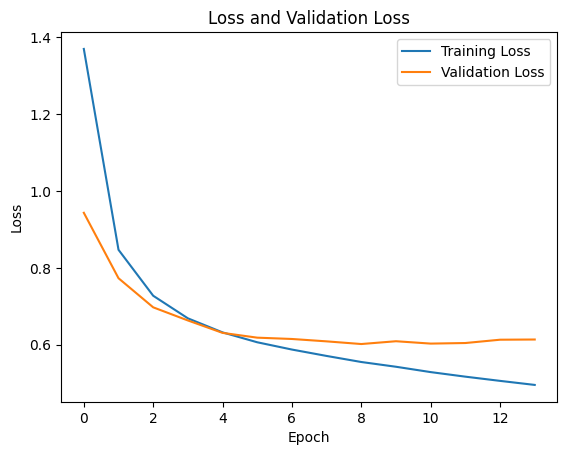

In [ ]:
import matplotlib.pyplot as plt

# Plota a perda (loss) e a perda de valida√ß√£o (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('/content/drive/My Drive/DatasetColab/ge_BiLSTM_glove6b100d.keras')
np.save("/content/drive/My Drive/DatasetColab/X_test_BiLSTM_glove6b100d.npy", X_test)
np.save("/content/drive/My Drive/DatasetColab/y_test_BiLSTM_glove6b100d.npy", y_test)

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Carrega arquivos pertinentes ao treinamento da rede neural e X_test e y_test (usados na avalia√ß√£o de resultados)
model = load_model('/content/drive/My Drive/DatasetColab/ge_BiLSTM_glove6b100d.keras')
X_test = np.load("/content/drive/My Drive/DatasetColab/X_test_BiLSTM_glove6b100d.npy")
y_test = np.load("/content/drive/My Drive/DatasetColab/y_test_BiLSTM_glove6b100d.npy")

# Carrega o tokenizer de um arquivo
with open('/content/drive/My Drive/DatasetColab/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Acur√°cia final:', accuracy)

896/896 [==============================] - 23s 23ms/step - loss: 0.6320 - accuracy: 0.7938
Acur√°cia final: 0.7937594056129456


In [ ]:
# Fazer as previs√µes do modelo para o conjunto de teste
y_pred = model.predict(X_test)

896/896 [==============================] - 22s 23ms/step


In [ ]:
#Transformar as previs√µes de volta em r√≥tulos
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calcular a matriz de confus√£o
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

conf_mat

array([[1233,   23,   12,   18,   13,   11,    7,   26,   62,    7,   26,
          11,    6,   10,   19,   16,   44,   13,   26,    7,    5],
       [  15,  415,    3,    4,    3,    3,    4,   13,    3,    2,    6,
           5,    8,   57,    6,   10,    4,    3,   20,    3,    1],
       [  21,   17, 1139,   16,   12,    7,    3,   19,    5,   58,   22,
          16,    9,    8,   18,   23,   30,   10,   15,    7,    5],
       [  16,   13,    4,  881,    0,    9,   14,   10,    3,    3,   16,
          10,    6,    8,   13,    9,   12,    3,   17,    9,   13],
       [  25,   12,    4,   19, 1221,    1,    1,   24,   11,    5,   43,
          18,    8,   11,   20,    9,   22,   13,   11,   10,   27],
       [  17,   15,    3,    5,    1,  404,    4,   17,    5,    3,    1,
           6,    5,    4,    2,    4,   15,    3,   17,    2,    1],
       [  14,   20,    3,   23,   10,    7,  645,   23,    7,    4,   19,
           6,   64,    6,    6,    9,   14,    5,   12,   13,    2],

In [ ]:
import pandas as pd

# L√™ o arquivo .csv
df = pd.read_pickle("/content/drive/My Drive/DatasetColab/ge_df.pkl")

# Total de classes (times de futebol)
classes = df['label'].nunique()

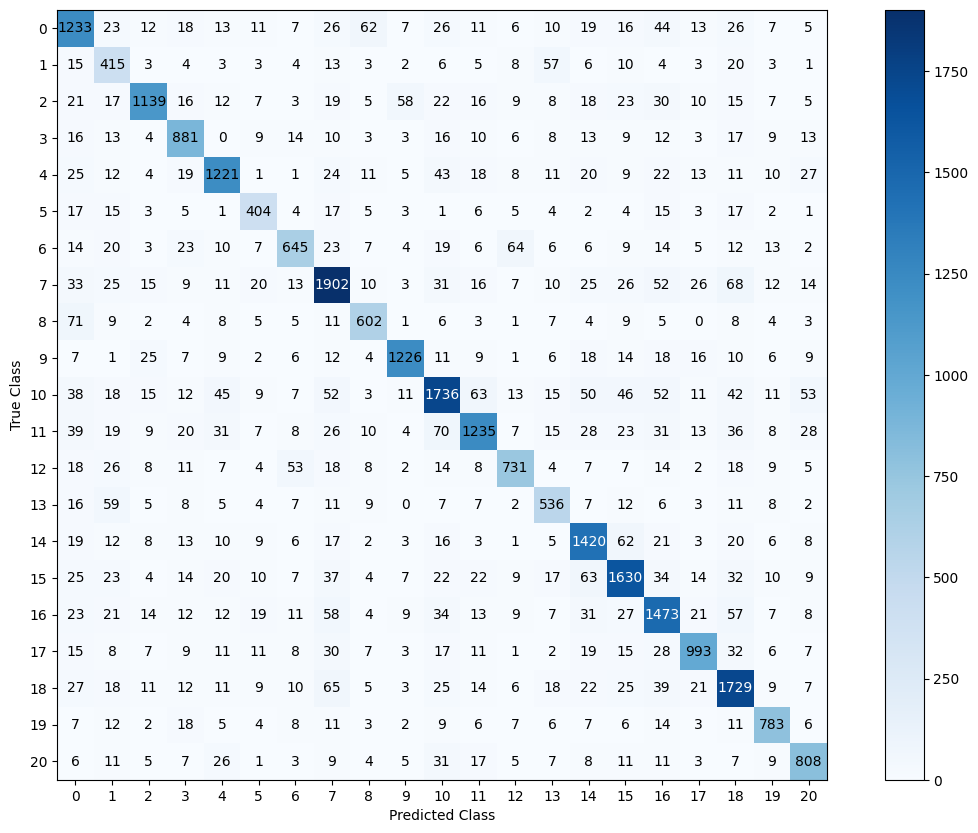

In [ ]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(15, 10))

# Define mapa de cores
cmap = plt.cm.Blues

# Plota matriz de confus√£o
plt.imshow(conf_mat, cmap=cmap)
plt.colorbar()

# Adiciona r√≥tulos a matriz
plt.xticks([int(i) for i in range(classes)], [str(i) for i in range(classes)])
plt.yticks([int(i) for i in range(classes)], [str(i) for i in range(classes)])

for i in range(classes):
    for j in range(classes):
        plt.text(j, i, str(conf_mat[i, j]), ha='center', va='center', color='white' if conf_mat[i, j] > len(y_true_labels)/ classes else 'black')

# Adiciona r√≥tulos dos eixos
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Mostra o plot
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcula precis√£o, recall e f1-score para cada classe
precisions = []
recalls = []
f1_scores = []
for i in range(classes):
    precision = precision_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    recall = recall_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    f1 = f1_score(y_true=y_true_labels == i, y_pred=y_pred_labels == i, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Printa resultados
for i in range(classes):
    print(f"Class '{i}': Precision={precisions[i]:.4f}, Recall={recalls[i]:.4f}, F1-Score={f1_scores[i]:.4f}")

# Calcula e printa a m√©dia dos f1-scores
f1_average = np.mean(f1_scores)
print(f"Average F1-Score: {f1_average:.4f}")

Class '0': Precision=0.7318, Recall=0.7730, F1-Score=0.7518
Class '1': Precision=0.5341, Recall=0.7058, F1-Score=0.6081
Class '2': Precision=0.8775, Recall=0.7801, F1-Score=0.8260
Class '3': Precision=0.7852, Recall=0.8241, F1-Score=0.8042
Class '4': Precision=0.8300, Recall=0.8059, F1-Score=0.8178
Class '5': Precision=0.7266, Recall=0.7566, F1-Score=0.7413
Class '6': Precision=0.7771, Recall=0.7072, F1-Score=0.7405
Class '7': Precision=0.7955, Recall=0.8170, F1-Score=0.8061
Class '8': Precision=0.7808, Recall=0.7839, F1-Score=0.7823
Class '9': Precision=0.9008, Recall=0.8652, F1-Score=0.8826
Class '10': Precision=0.8030, Recall=0.7541, F1-Score=0.7778
Class '11': Precision=0.8239, Recall=0.7409, F1-Score=0.7802
Class '12': Precision=0.8068, Recall=0.7505, F1-Score=0.7777
Class '13': Precision=0.7062, Recall=0.7393, F1-Score=0.7224
Class '14': Precision=0.7920, Recall=0.8534, F1-Score=0.8215
Class '15': Precision=0.8179, Recall=0.8097, F1-Score=0.8138
Class '16': Precision=0.7597, Reca

### Infer√™ncia

In [ ]:
# Criei um dataframe simples com uma not√≠cia s√≥ para aplicarmos a fun√ß√£o preprocess_data
import pandas as pd

value = """Santos diz que grupo do Flamengo na Libertadores √© dif√≠cil e mira tetracampeonato

Flamengo desfruta de dias livres para treinar com foco na final do Campeonato Carioca, mas tamb√©m j√° mira a estreia na Libertadores. A estreia na competi√ß√£o continental acontece na pr√≥xima quarta-feira, entre as finais do Estadual.

O primeiro jogo ser√° em Quito, no Equador, contra o Aucas, e o goleiro Santos comentou o desejo do Rubro-Negro em conquistar o tetracampeonato na Libertadores.

- A expectativa √© sempre muito boa para que essa competi√ß√£o comece. √â a principal competi√ß√£o do nosso continente. O grupo √© muito dif√≠cil, a gente sabe a dificuldade que √© a Libertadores. Cada time teve a sua dificuldade para se classificar. A gente est√° vivendo uma expectativa boa para a estreia, queremos fazer uma boa competi√ß√£o em busca do objetivo que √© ser campe√£o mais uma vez.

Mas, antes de focar na estreia da Libertadores, o Flamengo disputa a primeira partida da final com o Fluminense, no s√°bado. Para o goleiro, o tempo para treinar em meio ao calend√°rio apertado do futebol brasileiro √© algo a ser valorizado.

- Semana muito boa com essa pausa para treinarmos. Estamos muito focados nessa decis√£o. Os treinos est√£o com muita intensidade e a gente tem aproveitado o m√°ximo poss√≠vel para chegarmos preparados.

O Flamengo √© o atual campe√£o da Libertadores e luta pelo tetracampeonato. No Carioca, o Rubro-Negro tenta a revanche em cima do Fluminense, que terminou campe√£o na temporada de 2022. O segundo e decisivo jogo do Estadual acontece no domingo, dia 9.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pr√©-processamento
preprocess_data(df_predict, 'data')

# Convers√£o dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

# Tokeniza√ß√£o
sequences = tokenizer.texts_to_sequences(preprocessed_articles)

# Padding das sequ√™ncias para garantir que todas tenham o mesmo comprimento
data = pad_sequences(sequences)

# Fazer a previs√£o usando o modelo
predictions = model.predict(data)

Removendo pontua√ß√£o...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1493.17it/s]


Removendo n√∫meros...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1861.65it/s]


Removendo acentos e s√≠mbolos diversos...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1136.98it/s]


Convertendo para min√∫sculas...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 3006.67it/s]


Computando Lematiza√ß√£o...
Processando segmento 1 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 47.07it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espa√ßos vazios...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 2012.62it/s]


1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[4.9087359e-04, 2.0878924e-04, 5.0157442e-04, 1.3185853e-04,
        2.2089542e-03, 6.4655156e-05, 1.7983837e-05, 5.6940888e-04,
        2.5481852e-06, 2.5654686e-04, 8.1520826e-01, 1.1511928e-02,
        3.8676197e-05, 2.8938348e-06, 6.1320381e-05, 2.5625931e-04,
        1.2446906e-03, 1.6453256e-01, 2.3956098e-04, 1.9233347e-03,
        5.2733225e-04]], dtype=float32)

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 10


In [ ]:
from sklearn.preprocessing import LabelEncoder

# L√™ o arquivo .csv
df = pd.read_csv('/content/drive/My Drive/DatasetColab/ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os r√≥tulos de times de futebol para vari√°veis categ√≥ricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de vari√°vel categ√≥rica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: flamengo


### Infer√™ncia 2

In [ ]:
# Criei um dataframe simples e com uma not√≠cia s√≥ apenas por conta da fun√ß√£o preprocess_data

import pandas as pd

value = """Nova camisa do Corinthians: vazam imagens de supostos uniformes para 2023; veja fotos

Imagens de supostas novas camisas do Corinthians para 2023 vazaram nas redes sociais nessa quarta-feira. Foram divulgadas fotos do que seriam os modelos 1 e 2 do uniforme do Tim√£o.

Uma loja de um shopping na Zona Sul de S√£o Paulo j√° est√° comercializando as novas camisas branca e listrada. A reportagem do ge entrou em contato com o estabelecimento e teve a confirma√ß√£o de um funcion√°rio de que as pe√ßas j√° est√£o √† venda por R$ 300 (modelo de torcedor). Confira as imagens abaixo:

As supostas novas camisas do Corinthians para 2023 possui detalhes na cor vermelha ao redor da logomarca da Nike, fornecedora do material esportivo do clube.

Os uniformes alvinegros para este ano homenagear√£o a Democracia Corinthiana, movimento organizado na d√©cada de 1980. CLIQUE AQUI e saiba mais sobre o tema.

Usualmente, o Corinthians lan√ßa seus novos uniformes principais entre o fim de abril e o in√≠cio de maio. J√° a terceira camisa costuma ser estreada em setembro, m√™s de anivers√°rio do clube.

O Tim√£o volta a campo na pr√≥xima quinta-feira, na estreia da Libertadores, contra o Liverpool-URU, √†s 19h, no est√°dio Centen√°rio de Montevid√©u.
"""

# Crie um DataFrame com uma linha e a coluna 'data'
df_predict = pd.DataFrame(data={'data': [value]})

# Faz pr√©-processamento
preprocess_data(df_predict, 'data')

# Convers√£o dos dados para serem usados no modelo (rede neural)
preprocessed_articles = df_predict['data'].tolist()

# Tokeniza√ß√£o
sequences = tokenizer.texts_to_sequences(preprocessed_articles)

# Padding das sequ√™ncias para garantir que todas tenham o mesmo comprimento
data = pad_sequences(sequences)

# Fazer a previs√£o usando o modelo
predictions = model.predict(data)

Removendo pontua√ß√£o...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1025.00it/s]


Removendo n√∫meros...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1663.75it/s]


Removendo acentos e s√≠mbolos diversos...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 958.04it/s]


Convertendo para min√∫sculas...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 1912.59it/s]


Computando Lematiza√ß√£o...
Processando segmento 1 de 10


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 41.77it/s]


Processando segmento 2 de 10


0it [00:00, ?it/s]


Processando segmento 3 de 10


0it [00:00, ?it/s]


Processando segmento 4 de 10


0it [00:00, ?it/s]


Processando segmento 5 de 10


0it [00:00, ?it/s]


Processando segmento 6 de 10


0it [00:00, ?it/s]


Processando segmento 7 de 10


0it [00:00, ?it/s]


Processando segmento 8 de 10


0it [00:00, ?it/s]


Processando segmento 9 de 10


0it [00:00, ?it/s]


Processando segmento 10 de 10


0it [00:00, ?it/s]


Remover tokens com espa√ßos vazios...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 305.26it/s]


1/1 [==============================] - 0s 38ms/step


In [ ]:
predictions

array([[4.8945744e-06, 2.2905922e-07, 6.0897232e-06, 1.3830193e-05,
        3.1221356e-05, 1.2485384e-06, 4.7044409e-06, 9.9974483e-01,
        2.2312489e-07, 1.0135480e-05, 3.8598087e-06, 4.2463504e-05,
        2.0327768e-07, 1.0201612e-06, 4.0590781e-05, 5.1940962e-05,
        2.0751662e-05, 1.0438144e-05, 8.0751315e-06, 1.7004786e-06,
        1.7365032e-06]], dtype=float32)

In [ ]:
# Identificar a classe com a maior probabilidade
predicted_class = np.argmax(predictions)

# Exibir a classe prevista
print(f"Classe prevista: {predicted_class}")

Classe prevista: 7


In [ ]:
from sklearn.preprocessing import LabelEncoder

# L√™ o arquivo .csv
df = pd.read_csv('/content/drive/My Drive/DatasetColab/ge_news.csv')

# Cria um objeto LabelEncoder
le = LabelEncoder()

# Transforma os r√≥tulos de times de futebol para vari√°veis categ√≥ricas
df['label'] = le.fit_transform(df['club'])

original_class = le.inverse_transform([predicted_class]) # Transforma a classe predita de vari√°vel categ√≥rica para o nome do clube, de volta
print(f"Classe original: {original_class[0]}")

Classe original: corinthians


# Refer√™ncias

* https://nlp.stanford.edu/projects/glove/
* https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010